# SMOTE
This notebook is to demo some basic concepts on imbalanced classifcation using SMOTE.

## Imports and Seed

In [1]:
import pandas as pd
import numpy as np
np.random.seed(seed=42)

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

## Data Generation

In [2]:
default_age = np.random.randint(12, 18, size=25) * np.maximum(np.random.randn(25),1)
default_balance = np.random.randint(50000,100000, size=25)
default_age_2 = np.random.randint(12,100, size=10)
default_balance_2 = np.random.randint(0, 90000, size=10)
paid_age = np.random.randint(12, 100, size=500)
paid_balance = np.random.randint(0, 90000, size=500)

In [3]:
df_default = pd.DataFrame({'age': default_age, 'balance': default_balance})
df_default['defaulted'] = 1
df_default_2 = pd.DataFrame({'age': default_age_2, 'balance': default_balance_2})
df_default_2['defaulted'] = 1
df_paid = pd.DataFrame({'age': paid_age, 'balance': paid_balance})
df_paid['defaulted'] = 0
df = pd.concat([df_default, df_default_2, df_paid])

## Train Test Split

In [4]:
x = df.loc[:, ['age', 'balance']]
y = df.loc[:, 'defaulted']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

## EDA
Setup helper functions to provide consistent scatter plots, count plots, and decision boundary plots

In [5]:
def plot_scatter(df_x: pd.DataFrame, s_y: pd.Series, title: str, ax=None):

    # Plot scatter
    ax = sns.scatterplot(x=df_x.age, y=df_x.balance, hue=s_y, ax=ax)

    # Default X and Y bounds, set title
    ax.set_xbound(df_x.age.min(), df_x.age.max())
    ax.set_ybound(df_x.balance.min(), df_x.balance.max())
    ax.set_title(title)


def plot_count(s_y: pd.Series, title: str, ax=None):

    # Plot counts
    ax = sns.countplot(x=s_y, ax=ax)

    # Label each bar
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0].mean()
        y=p.get_bbox().get_points()[1,1]
        ax.annotate(f'{y:.0f}', (x,y+5), ha='center', va='bottom', color=p.get_facecolor())

    # Default y bounds and title
    ax.set_ybound(0, 500)
    ax.set_title(title)


def plot_scatter_and_count(df_x: pd.DataFrame, s_y: pd.Series, title: str):

    # Calc fig size
    x_fig, y_fig = plt.rcParamsDefault['figure.figsize']
    new_fig_size = (x_fig*2, y_fig)
    
    # Create matplotlib objects and bind scatter and count plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=new_fig_size)
    fig.suptitle(title)
    scatter = plot_scatter(df_x, s_y, 'Scatter by Age and Balance', axes[0])
    count = plot_count(s_y, 'Count of Labels', axes[1])
    for ax in axes:
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.show()


In [6]:
def plot_bounds(x: pd.DataFrame, y: pd.Series, x_orig: pd.DataFrame, y_orig: pd.Series, title: str):

    # Fit logistic regression classifier for boundaries
    clf = LogisticRegression()
    clf.fit(x.loc[:, ['age', 'balance']], y)

    # Meshgrid for every possible combination given some spacing
    age_min, age_max = x_orig.age.min(), x_orig.age.max()
    balance_min, balance_max = x_orig.balance.min(), x_orig.balance.max()
    xx, yy = np.meshgrid(np.arange(age_min, age_max, 0.5), np.arange(balance_min, balance_max, 1.0))
    df_mesh = pd.DataFrame({'age': xx.ravel(), 'balance': yy.ravel()})

    # Predictions for each mesh x/y pair
    z = clf.predict(df_mesh)

    # Plot contours - x/y pairs, predictions, default colors
    plt.contourf(xx, yy, z.reshape(xx.shape), cmap=ListedColormap(['lightsteelblue', 'blanchedalmond']))

    # Plot scatter of data on top of contour
    ax = sns.scatterplot(x=x_orig.age, y=x_orig.balance, hue=y_orig)
    ax.set_xbound(age_min, age_max)
    ax.set_ybound(balance_min, balance_max)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    # Calculate predictions and various classification scores
    pred = clf.predict(x_orig.loc[:, ['age', 'balance']])
    acc = accuracy_score(y_orig, pred)
    prec = precision_score(y_orig, pred)
    recall = recall_score(y_orig, pred)
    f1 = f1_score(y_orig, pred)

    # Title
    ax.set_title('Decision Bounds - ' + title + f'\nAccuracy: {acc:.2%}\nPrecision: {prec:.2%}\nRecall: {recall:.2%}\nF1 Score: {f1:.2%}')

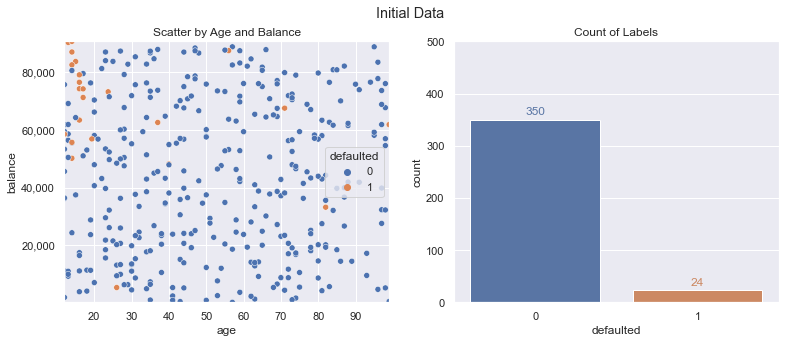

In [7]:
plot_scatter_and_count(x_train, y_train, 'Initial Data')

C:\Users\barre\Miniconda3\envs\sliced2\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


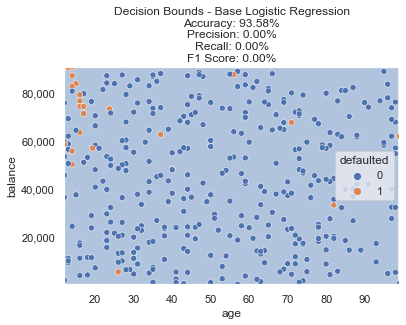

In [8]:
plot_bounds(x_train, y_train, x_train, y_train, 'Base Logistic Regression')

## SMOTE (Over Sampling)
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [9]:
sm = SMOTE(random_state=42)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

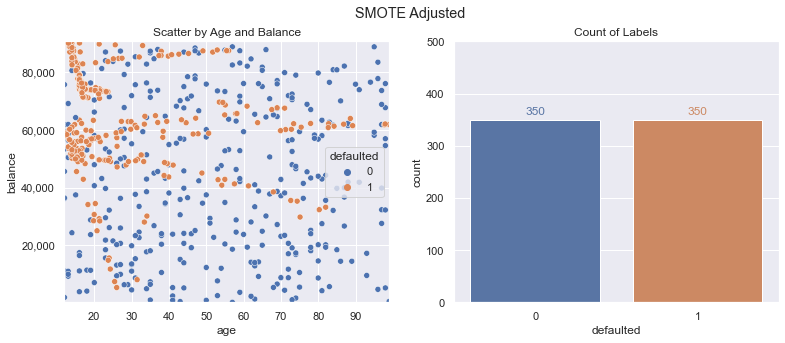

In [10]:
plot_scatter_and_count(x_train_smote, y_train_smote, 'SMOTE Adjusted')

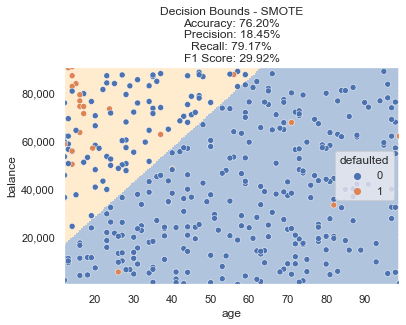

In [11]:
plot_bounds(x_train_smote, y_train_smote, x_train, y_train, 'SMOTE')

## Edited Nearest Neighbours (Under Sampling)
https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html

In [12]:
enn = EditedNearestNeighbours()
x_train_enn, y_train_enn = enn.fit_resample(x_train, y_train)

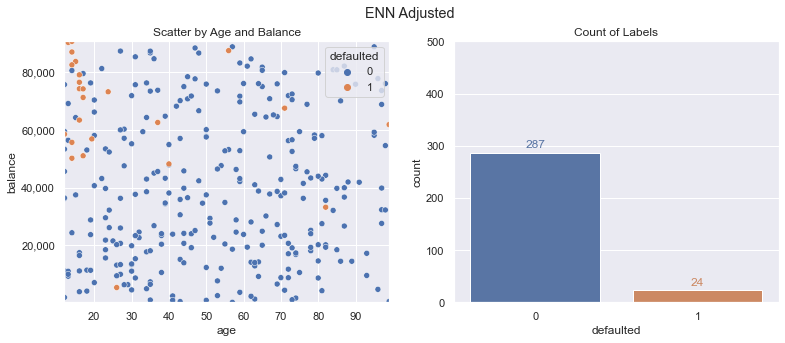

In [13]:
plot_scatter_and_count(x_train_enn, y_train_enn, 'ENN Adjusted')

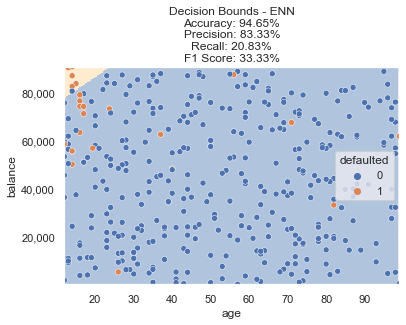

In [14]:
plot_bounds(x_train_enn, y_train_enn, x_train, y_train, 'ENN')

## SMOTE + ENN
https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html

In [15]:
smoteenn = SMOTEENN(random_state=42)
x_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(x_train, y_train)

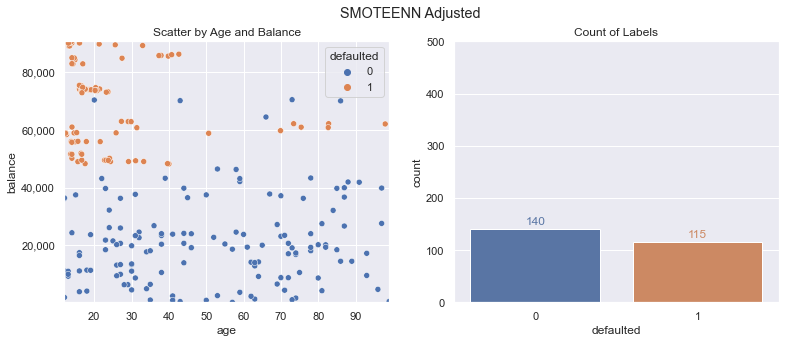

In [16]:
plot_scatter_and_count(x_train_smoteenn, y_train_smoteenn, 'SMOTEENN Adjusted')

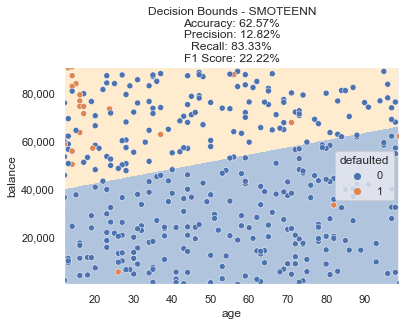

In [17]:
plot_bounds(x_train_smoteenn, y_train_smoteenn, x_train, y_train, 'SMOTEENN')

## Custom Sampling + SMOTE

In [18]:
# Grab copy of training data
x_train_custom = x_train.copy()
x_train_custom.reset_index(drop=True, inplace=True)
y_train_custom = y_train.copy()
y_train_custom.reset_index(drop=True, inplace=True)

# Scale Features
scaler = StandardScaler()
x_train_custom_scaled = scaler.fit_transform(x_train_custom)

# Fit KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_custom_scaled, y_train_custom)
preds = pd.DataFrame(knn.predict_proba(x_train_custom_scaled))
preds.columns = ['label_0', 'label_1']

# Bind to custom train dataset
x_train_custom['knn_minority_class_proba'] = preds['label_1']

# Filter X and Y Custom
x_train_custom_filtered = x_train_custom.loc[(x_train_custom.knn_minority_class_proba > 0.5) | (y_train_custom == 0), :]
y_train_custom_filtered = y_train_custom.loc[(x_train_custom.knn_minority_class_proba > 0.5) | (y_train_custom == 0)]


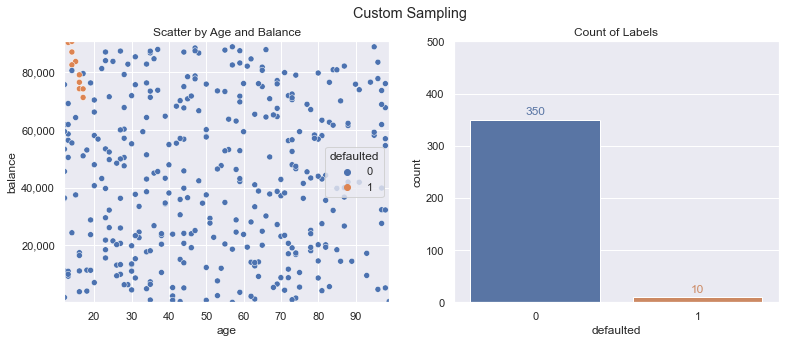

In [19]:
plot_scatter_and_count(x_train_custom_filtered, y_train_custom_filtered, 'Custom Sampling')

In [20]:
sm_custom = SMOTE(random_state=42)
x_train_smote_custom, y_train_smote_custom = sm.fit_resample(x_train_custom_filtered, y_train_custom_filtered)

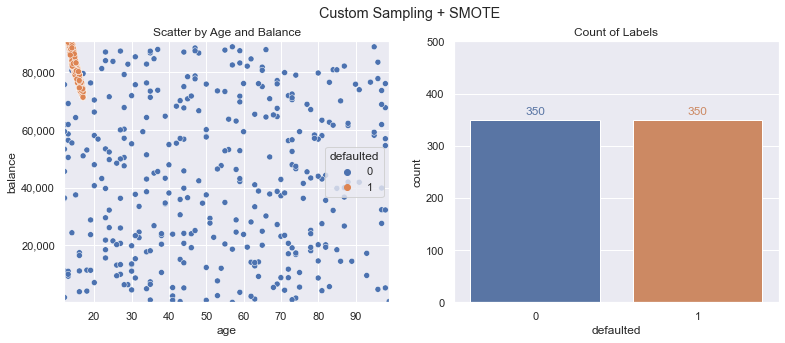

In [21]:
plot_scatter_and_count(x_train_smote_custom, y_train_smote_custom, 'Custom Sampling + SMOTE')

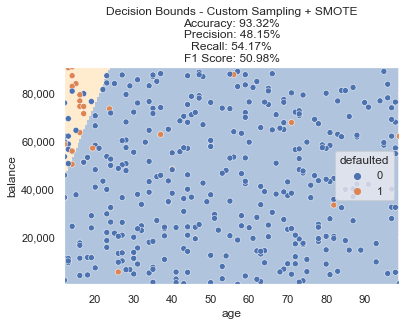

In [22]:
plot_bounds(x_train_smote_custom, y_train_smote_custom, x_train, y_train, 'Custom Sampling + SMOTE')